In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [2]:
def find_method_descriptor(image, method=None):
    """
    Compute key points and feature descriptors using a specific method.
    """
    # Mapping method names to feature detection objects
    method_desc = {
        'sift': cv2.SIFT_create(),
        # 'surf': cv2.xfeatures2d.SURF_create()
    }
    
    # Ensure that a valid method is provided
    if method not in method_desc:
        print("Invalid feature detection method. Please choose from: 'sift', 'surf'")
        return None, None
    
    # Select the descriptor based on the method provided
    descriptor = method_desc[method]
    # kp = sift.detect(gimg,None)
    # img=cv2.drawKeypoints(gimg,kp,img)
    # Detect and extract features from the image
    keypoints, features = descriptor.detectAndCompute(image, None)

    return keypoints, features

In [3]:
def matchKeyPointsBF(featuresA, featuresB):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    # Sort the features in orderdistance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [4]:
def matchKeyPointsKNN(featuresA, featuresB, ratio):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [5]:
def getHomography(kpsA, kpsB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

The train image will be the one that will be used as reference and other ones will be sticthed to this.

C:\Users\Srinivasan M\AppData\Local\Temp\ipykernel_5716\4294403920.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_image = imageio.imread("./Cubbon_Park/flight3.jpg")
C:\Users\Srinivasan M\AppData\Local\Temp\ipykernel_5716\4294403920.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  query_image = imageio.imread("./Cubbon_Park/flight2.jpg")


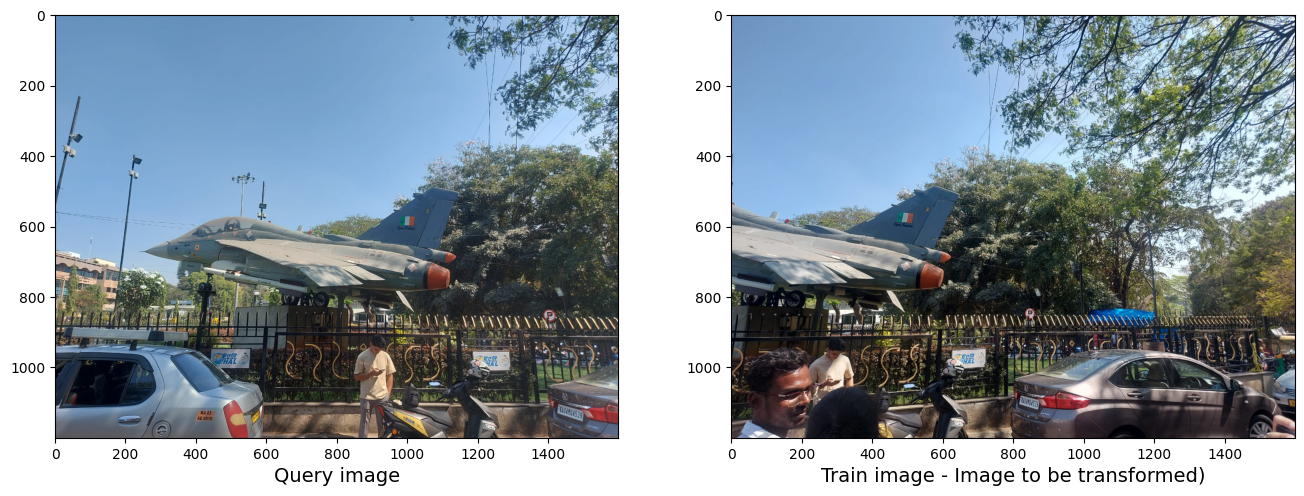

In [6]:
train_image = imageio.imread("./Cubbon_Park/flight3.jpg")
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)

query_image = imageio.imread("./Cubbon_Park/flight2.jpg")
query_image_gray = cv2.cvtColor(query_image,cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_image, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_image, cmap="gray")
ax2.set_xlabel("Train image - Image to be transformed)", fontsize=14)

# Statement to be printed below the images
plt.show()

In [7]:
detector = "sift"
keypointsA, featuresA = find_method_descriptor(train_image_gray, method=detector)
keypointsB, featuresB = find_method_descriptor(query_image_gray, method=detector)

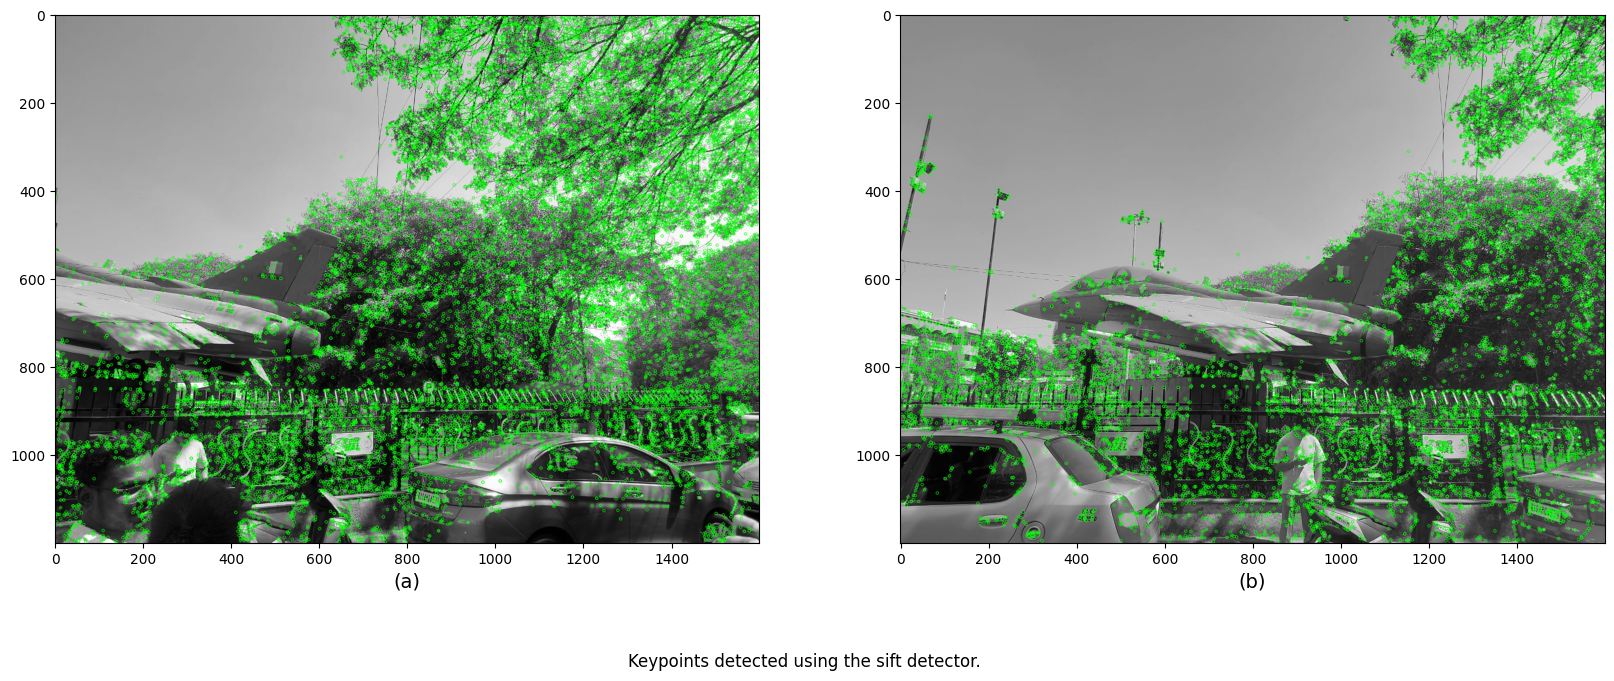

In [8]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(train_image_gray,keypointsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_image_gray,keypointsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)
statement = f'Keypoints detected using the {detector} detector.'

# Print the statement below the images
fig.text(0.5, 0.01, statement, ha='center', fontsize=12)
plt.show()

Raw matches (knn): 18813


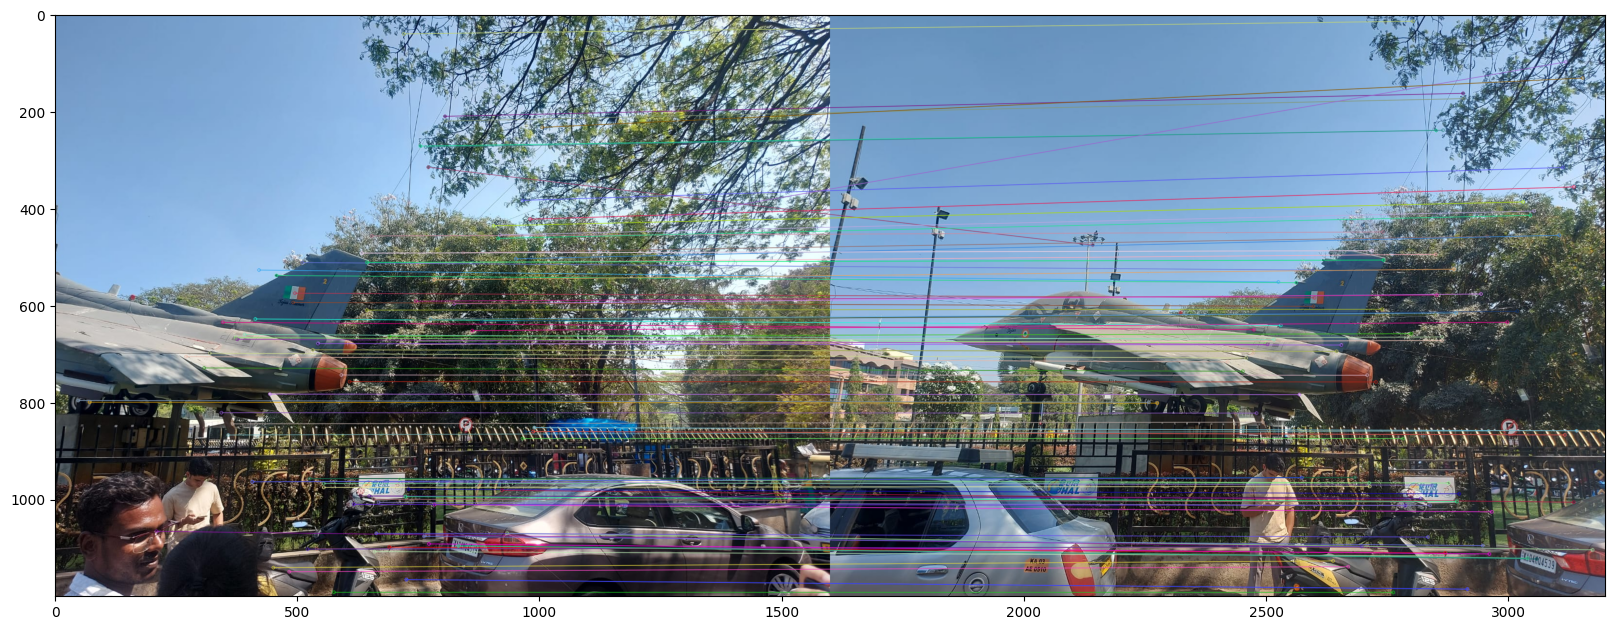

In [9]:
feature_match = "knn"
fig = plt.figure(figsize=(20, 8))

if feature_match == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB)
    img3 = cv2.drawMatches(train_image, keypointsA, query_image, keypointsB, matches[:100],
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_match == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75)
    img3 = cv2.drawMatches(train_image, keypointsA, query_image, keypointsB, np.random.choice(matches, 100),
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

In [10]:
M = getHomography(keypointsA, keypointsB, matches, reprojThresh=5)
if M is None:
    print("Error!")
(matches, H, status) = M
# print(H)

In [11]:
result = cv2.warpPerspective(train_image, H,
			(train_image.shape[1] + query_image.shape[1], train_image.shape[0]))
result[0:query_image.shape[0], 0:query_image.shape[1]] = query_image

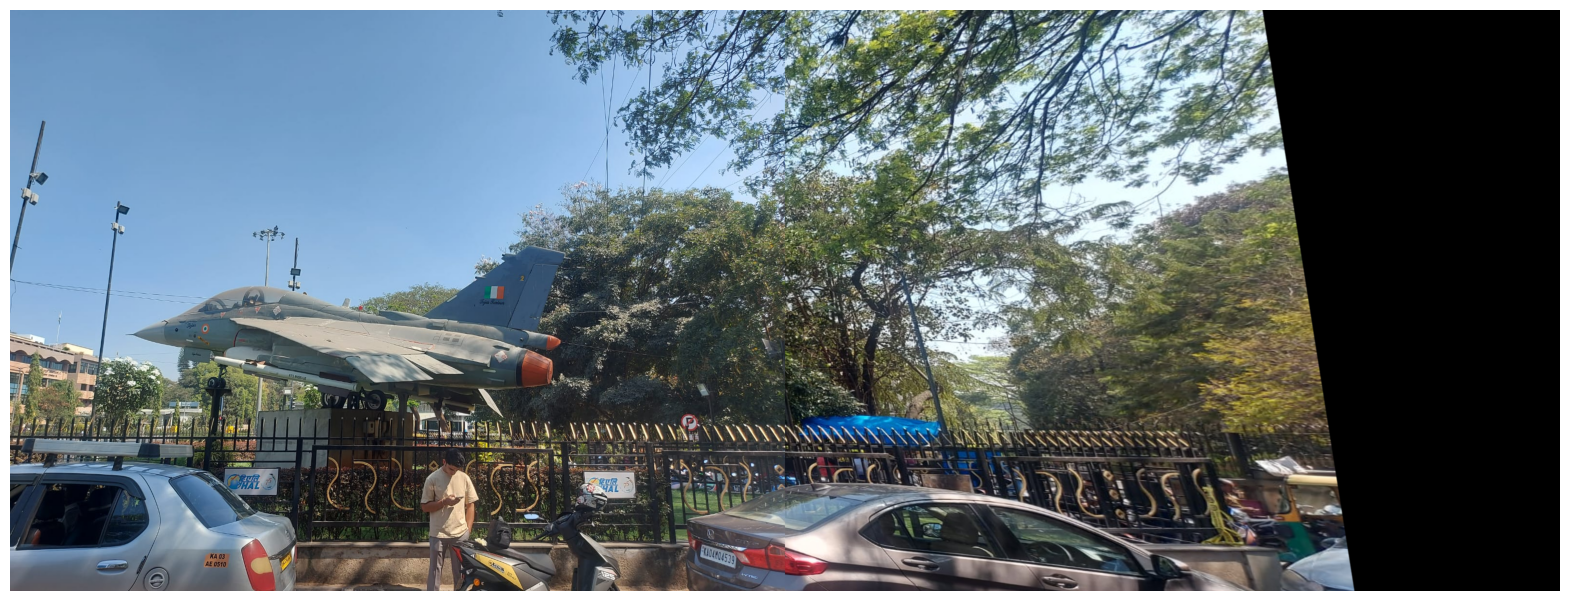

In [12]:
# result = stitch_images(train_image, query_image, H)

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

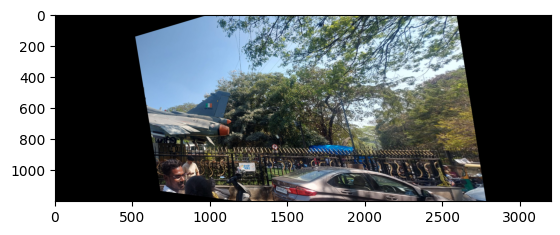

In [13]:
# result = stitch_images(train_image, query_image, H)
result = cv2.warpPerspective(train_image, H, (query_image.shape[1]+train_image.shape[1], train_image.shape[0]))
# plt.figure(figsize=(20,10))
plt.imshow(result)

# plt.axis('off')
plt.show()